# checking if i'm right about the attention matrix

In [1]:
import torch
import einops
import numpy as np

from scale_alibi.model import get_scale_alibi

In [25]:
square_size_sm = 4
square_size_lg = 8

img_sm = np.arange(square_size_sm**2).reshape(square_size_sm,square_size_sm)
img_sm = einops.rearrange(img_sm, 'h w -> 1 1 h w')
img_sm

array([[[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [12, 13, 14, 15]]]])

In [26]:
img_lg = np.arange(square_size_lg**2).reshape(square_size_lg,square_size_lg)
img_lg = img_lg // 2
img_lg = img_lg[:4,:]

img_lg = einops.repeat(img_lg, 'h w -> (h 2) w')

img_lg = einops.rearrange(img_lg, 'h w -> 1 1 h w')

img_lg

array([[[[ 0,  0,  1,  1,  2,  2,  3,  3],
         [ 0,  0,  1,  1,  2,  2,  3,  3],
         [ 4,  4,  5,  5,  6,  6,  7,  7],
         [ 4,  4,  5,  5,  6,  6,  7,  7],
         [ 8,  8,  9,  9, 10, 10, 11, 11],
         [ 8,  8,  9,  9, 10, 10, 11, 11],
         [12, 12, 13, 13, 14, 14, 15, 15],
         [12, 12, 13, 13, 14, 14, 15, 15]]]])

In [27]:
patch_size = 2

sm = einops.rearrange(
    img_sm,
    'b c (h i) (w j) -> b (h w) (c i j)',
    i=patch_size,
    j=patch_size
)

lg = einops.rearrange(
    img_lg,
    'b c (h i) (w j) -> b (h w) (c i j)',
    i=patch_size,
    j=patch_size
)

In [5]:
sm

array([[[ 0,  1,  4,  5],
        [ 2,  3,  6,  7],
        [ 8,  9, 12, 13],
        [10, 11, 14, 15]]])

In [29]:
lg

array([[[ 0,  0,  0,  0],
        [ 1,  1,  1,  1],
        [ 2,  2,  2,  2],
        [ 3,  3,  3,  3],
        [ 4,  4,  4,  4],
        [ 5,  5,  5,  5],
        [ 6,  6,  6,  6],
        [ 7,  7,  7,  7],
        [ 8,  8,  8,  8],
        [ 9,  9,  9,  9],
        [10, 10, 10, 10],
        [11, 11, 11, 11],
        [12, 12, 12, 12],
        [13, 13, 13, 13],
        [14, 14, 14, 14],
        [15, 15, 15, 15]]])

In [70]:
sa_mask = get_scale_alibi(1, 16)
sa_mask = sa_mask.detach().squeeze(0).squeeze(0).numpy() * -1024
sa_mask = sa_mask.astype(int)
sa_mask = sa_mask[:,::4]

sa_mask

array([[ 0,  4,  8, 12],
       [ 4,  5,  8, 12],
       [ 8,  8, 11, 14],
       [12, 12, 14, 16],
       [ 4,  0,  4,  8],
       [ 5,  4,  5,  8],
       [ 8,  8,  8, 11],
       [12, 12, 12, 14],
       [ 8,  4,  0,  4],
       [ 8,  5,  4,  5],
       [11,  8,  8,  8],
       [14, 12, 12, 12],
       [12,  8,  4,  0],
       [12,  8,  5,  4],
       [14, 11,  8,  8],
       [16, 14, 12, 12]])

In [71]:
sm_idx = 3
lg_idx = 15

print(f'sm   {sm[0][sm_idx]}')
print(f'lg   {lg[0][lg_idx]}')
print(f'attn {sa_mask[lg_idx][sm_idx]}')

sm   [10 11 14 15]
lg   [15 15 15 15]
attn 12


array([[ 0,  4,  8, 12,  4,  5,  8, 12,  8,  8, 11, 14, 12, 12, 14, 16],
       [ 4,  0,  4,  8,  5,  4,  5,  8,  8,  8,  8, 11, 12, 12, 12, 14],
       [ 8,  4,  0,  4,  8,  5,  4,  5, 11,  8,  8,  8, 14, 12, 12, 12],
       [12,  8,  4,  0, 12,  8,  5,  4, 14, 11,  8,  8, 16, 14, 12, 12],
       [ 4,  5,  8, 12,  0,  4,  8, 12,  4,  5,  8, 12,  8,  8, 11, 14],
       [ 5,  4,  5,  8,  4,  0,  4,  8,  5,  4,  5,  8,  8,  8,  8, 11],
       [ 8,  5,  4,  5,  8,  4,  0,  4,  8,  5,  4,  5, 11,  8,  8,  8],
       [12,  8,  5,  4, 12,  8,  4,  0, 12,  8,  5,  4, 14, 11,  8,  8],
       [ 8,  8, 11, 14,  4,  5,  8, 12,  0,  4,  8, 12,  4,  5,  8, 12],
       [ 8,  8,  8, 11,  5,  4,  5,  8,  4,  0,  4,  8,  5,  4,  5,  8],
       [11,  8,  8,  8,  8,  5,  4,  5,  8,  4,  0,  4,  8,  5,  4,  5],
       [14, 11,  8,  8, 12,  8,  5,  4, 12,  8,  4,  0, 12,  8,  5,  4],
       [12, 12, 14, 16,  8,  8, 11, 14,  4,  5,  8, 12,  0,  4,  8, 12],
       [12, 12, 12, 14,  8,  8,  8, 11,  5,  4,  5,

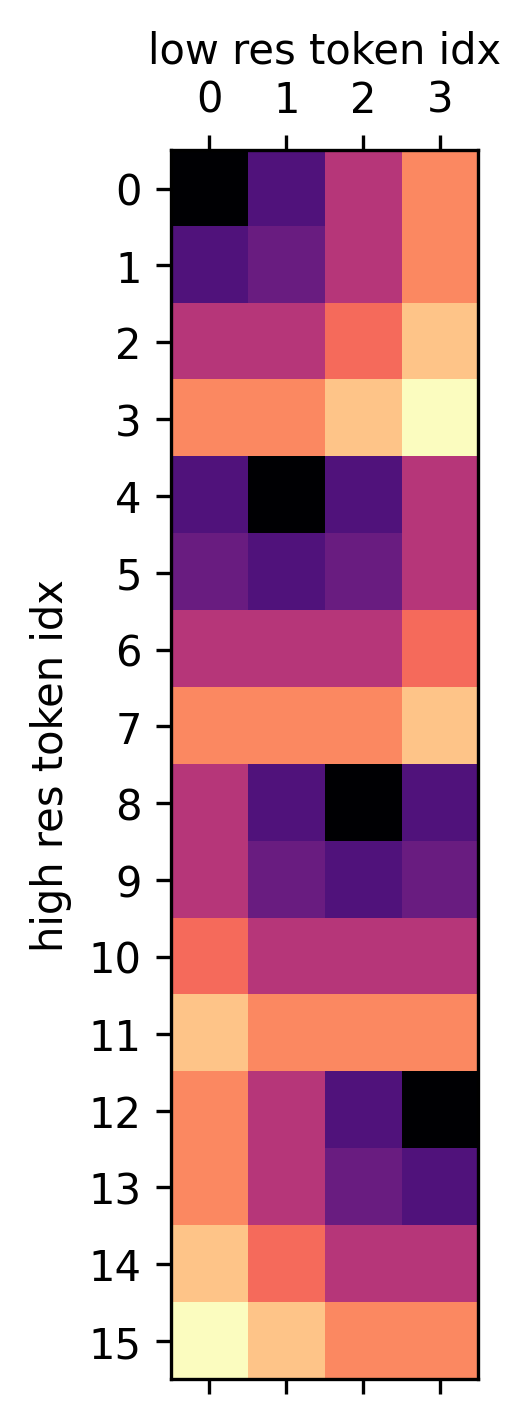

In [114]:
sa_mask = get_scale_alibi(1, 16)
sa_mask = sa_mask.detach().squeeze(0).squeeze(0).numpy() * -1024
sa_mask = sa_mask.astype(int)
sa_mask = sa_mask[:,::4]

sa_mask

from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.rcParams['figure.dpi'] = 300

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel('low res token idx')
ax.xaxis.set_label_position('top') 
ax.set_ylabel('high res token idx')

plt.tight_layout()
ax.matshow(sa_mask,cmap='magma')
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(1))
# plt.show()

plt.savefig('./salibi_attn.png')
# plt.matshow(sa_mask, cmap='magma')